# Exercise 1 — Simplified Mastermind (bit pattern search)
#### Tasks
1. Build the simulation environment
   - Generate random bit pattern of specific size
   - Random guessing: measure attempts/time to find correct pattern → plot boxplots for pattern sizes (2, 4, 8, 12, 16, …)
   - Fitness function: number of matching bits between guess and target
   - Mutation-based improvement: flip one bit at a time, accept only if fitness increases (stop after 1000 mutations or success)

2. Population-based search
   - Start with population of 100 random patterns, evaluate fitness
   - Select best 30%, mutate to fill rest
   - Repeat until stagnation (no improvement)
   - Compare methods by runtime and attempts → boxplots (30 tests)

3. Crossover
   - Implement crossover and compare similarly.

🧩 Cell 1 — Imports & basic setup

In [1]:
# Step 1: Import basic libraries
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean


⚙️ Cell 2 — Utility functions
### Random Bit Pattern, Fitness and Mutation functions
- Generates reproducible random bitstrings for any size.
- Accepts an optional seed parameter (so you can use a fixed set of seeds to reproduce the experiments).
- Fitness function that returns an integer equal to the number of matching bits (the complement of Hamming distance).
- Maximum = pattern length when all bits match → exactly as required.

In [2]:
# Generate a random bit pattern of a given size (string of 0s and 1s).
def random_pattern(size, seed=None):
    if seed is not None:
        random.seed(seed)
    return ''.join(random.choice('01') for _ in range(size))

# Compute fitness: number of matching bits between guess and target
def fitness(guess, target):
    return sum(g == t for g, t in zip(guess, target))

# Flip one bit in a pattern (mutation)
def mutate(pattern):
    pattern = list(pattern)
    idx = random.randrange(len(pattern))
    pattern[idx] = '1' if pattern[idx] == '0' else '0'
    return ''.join(pattern)


🔁 Cell 3 — Random guessing search functionalities
### Generate random patterns repeatedly and measure attempts / time
- Uses 30 trials per size, reproducible seeds.
- Produces two boxplots (Attempts vs Bits, Time vs Bits).
- You can simply stop your loop if a run exceeds one hour (break), but the logic is otherwise identical.


In [3]:
# Try random guesses until we find the correct pattern
def random_search(target):
    attempts = 0
    start_time = time.time()
    while True:
        attempts += 1
        guess = random_pattern(len(target))
        if guess == target:
            break
    elapsed = time.time() - start_time
    return attempts, elapsed


📈 Cell 4 — Test random search for increasing bit sizes
### Experiment & graphs implemented

In [4]:
sizes = [2, 4, 8, 12, 16]
n_trials = 30
results_attempts, results_time = {}, {}

for size in sizes:
    attempts_list, time_list = [], []
    target = random_pattern(size, seed=42)
    for seed in range(n_trials):
        random.seed(seed)
        a, t = random_search(target)
        attempts_list.append(a)
        time_list.append(t)
    results_attempts[size] = attempts_list
    results_time[size] = time_list
    print(f"Size {size} bits: mean attempts = {np.mean(attempts_list):.1f}, mean time = {np.mean(time_list):.4f}s")


Size 2 bits: mean attempts = 3.2, mean time = 0.0000s
Size 4 bits: mean attempts = 17.0, mean time = 0.0000s
Size 8 bits: mean attempts = 296.9, mean time = 0.0010s
Size 12 bits: mean attempts = 5448.0, mean time = 0.0236s
Size 16 bits: mean attempts = 98070.8, mean time = 0.5636s


📊 Cell 5 — Boxplots for attempts and time
### Experiment & graphs implemented

/tmp/ipykernel_47834/642743400.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_attempts[s] for s in sizes], labels=sizes)
/tmp/ipykernel_47834/642743400.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_time[s] for s in sizes], labels=sizes)


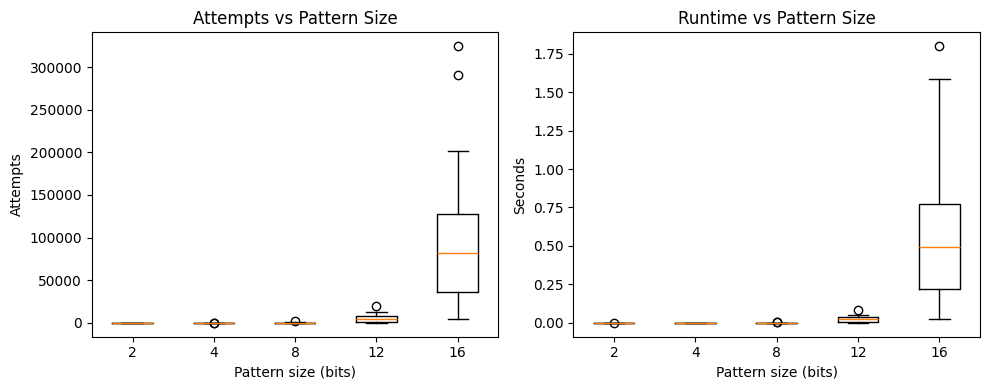

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot([results_attempts[s] for s in sizes], labels=sizes)
plt.title("Attempts vs Pattern Size")
plt.xlabel("Pattern size (bits)")
plt.ylabel("Attempts")

plt.subplot(1,2,2)
plt.boxplot([results_time[s] for s in sizes], labels=sizes)
plt.title("Runtime vs Pattern Size")
plt.xlabel("Pattern size (bits)")
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()


🧬 Cell 6 — Mutation-based hill climbing
### Create a mutation function and accept only if fitness improves
Use mutate() function in a loop where the change is accepted only if it generates a better solution.
- Performs up to 1000 mutations.
- Accepts only improving mutations.


In [6]:
def mutation_search(target, max_iter=1000):
    current = random_pattern(len(target))
    best_fit = fitness(current, target)
    for i in range(max_iter):
        new = mutate(current)
        new_fit = fitness(new, target)
        if new_fit > best_fit:
            current, best_fit = new, new_fit
        if current == target:
            return i+1, True  # iterations, success
    return max_iter, current == target


📉 Cell 7 — Evaluate mutation search over 30 runs
### Test & visualize in Cell 7
- Records convergence and success rate (so you can empirically answer “Does it always converge?”).
- Plots boxplot of iteration counts.


Mean iterations: 31.2
Success rate: 100.0%


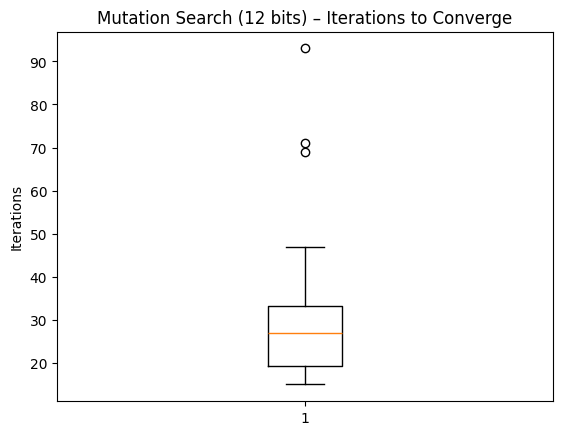

In [7]:
n_trials = 30
iters_list, success_list = [], []

target = random_pattern(12, seed=123)

for seed in range(n_trials):
    random.seed(seed)
    iters, success = mutation_search(target)
    iters_list.append(iters)
    success_list.append(success)

print(f"Mean iterations: {np.mean(iters_list):.1f}")
print(f"Success rate: {np.mean(success_list)*100:.1f}%")
plt.boxplot(iters_list)
plt.title("Mutation Search (12 bits) – Iterations to Converge")
plt.ylabel("Iterations")
plt.show()


### Repeat experiment 30 times and compute convergence statistics
🧪 Cell 8 — Population-based evolutionary search

In [8]:
def population_search(target, pop_size=100, select_ratio=0.3, max_gen=100):
    size = len(target)
    pop = [random_pattern(size) for _ in range(pop_size)]
    best_history = []
    for gen in range(max_gen):
        fits = [fitness(p, target) for p in pop]
        best_fit = max(fits)
        best_history.append(best_fit)
        if best_fit == size:
            break
        # Selection
        sorted_pop = [p for _, p in sorted(zip(fits, pop), reverse=True)]
        survivors = sorted_pop[:int(pop_size*select_ratio)]
        # Generate new via mutation
        offspring = [mutate(random.choice(survivors)) for _ in range(pop_size - len(survivors))]
        pop = survivors + offspring
        # Check stagnation
        if len(best_history) > 5 and len(set(best_history[-5:])) == 1:
            break
    return gen+1, max(best_history)


### Generate 2D Gauussian data set
⚙️ Cell 9 — Evaluate population search

Average generations: 4.3


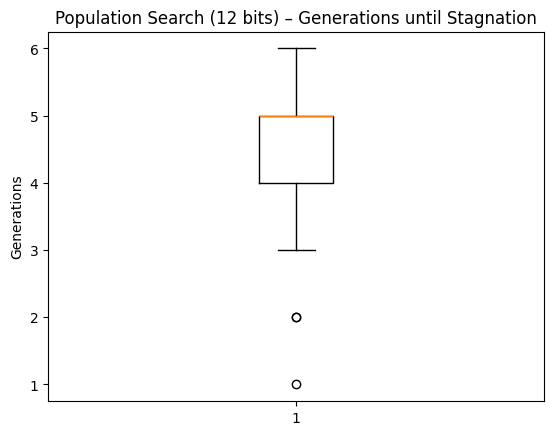

In [9]:
n_trials = 30
gens_list = []
target = random_pattern(12, seed=7)

for seed in range(n_trials):
    random.seed(seed)
    gens, best = population_search(target)
    gens_list.append(gens)

print(f"Average generations: {np.mean(gens_list):.1f}")
plt.boxplot(gens_list)
plt.title("Population Search (12 bits) – Generations until Stagnation")
plt.ylabel("Generations")
plt.show()


### Train same perceptron on gaussian data
🧩 Cell 10 — Crossover operator

In [10]:
def crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    child = p1[:point] + p2[point:]
    return child


### Visualize classification regions & confusion matrix
🧬 Cell 11 — Population search with crossover

In [11]:
def population_search_crossover(target, pop_size=100, select_ratio=0.3, max_gen=100):
    size = len(target)
    pop = [random_pattern(size) for _ in range(pop_size)]
    best_history = []
    for gen in range(max_gen):
        fits = [fitness(p, target) for p in pop]
        best_fit = max(fits)
        best_history.append(best_fit)
        if best_fit == size:
            break
        sorted_pop = [p for _, p in sorted(zip(fits, pop), reverse=True)]
        survivors = sorted_pop[:int(pop_size*select_ratio)]
        offspring = []
        for _ in range(pop_size - len(survivors)):
            p1, p2 = random.sample(survivors, 2)
            child = crossover(p1, p2)
            # optional mutation
            if random.random() < 0.3:
                child = mutate(child)
            offspring.append(child)
        pop = survivors + offspring
        if len(best_history) > 5 and len(set(best_history[-5:])) == 1:
            break
    return gen+1, max(best_history)


### Compute average metrics over 30 random runs
📊 Cell 12 — Compare methods

Random Search: mean=3202.6, std=2720.1, time=0.42s
Mutation Search: mean=31.2, std=17.8, time=0.00s
Population: mean=4.3, std=1.3, time=0.04s
Crossover: mean=3.6, std=0.9, time=0.04s


/tmp/ipykernel_47834/1937171503.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[m] for m in methods.keys()], labels=list(methods.keys()))


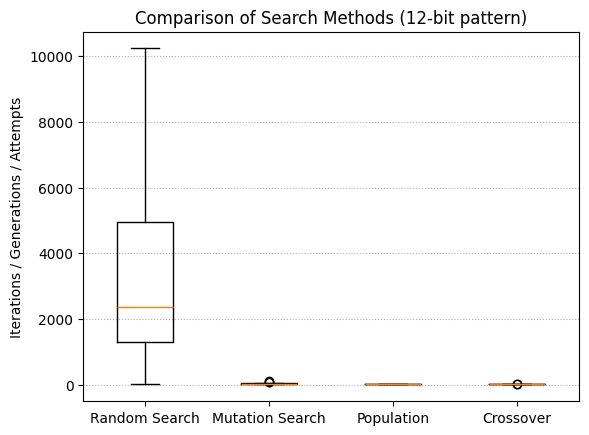

In [12]:
methods = {
    "Random Search": lambda t: random_search(t),
    "Mutation Search": lambda t: mutation_search(t),
    "Population": lambda t: population_search(t),
    "Crossover": lambda t: population_search_crossover(t)
}

target = random_pattern(12, seed=123)
results = {}

for name, func in methods.items():
    trials = []
    start = time.time()
    for seed in range(30):
        random.seed(seed)
        res = func(target)
        trials.append(res[0])
    results[name] = trials
    print(f"{name}: mean={np.mean(trials):.1f}, std={np.std(trials):.1f}, time={time.time()-start:.2f}s")

plt.boxplot([results[m] for m in methods.keys()], labels=list(methods.keys()))
plt.ylabel("Iterations / Generations / Attempts")
plt.title("Comparison of Search Methods (12-bit pattern)")
plt.grid(True, axis='y', linestyle=':')
plt.show()
